In [128]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('ffire.csv')

In [7]:
df.head

<bound method NDFrame.head of          X      Y   FFMC    DMC     DC    ISI   temp     RH   wind   rain  \
0    0.731  0.769  0.186  0.178  0.290  0.451  0.621  0.797  0.763  0.448   
1    0.750  0.313  0.428  0.042  0.972  0.050  0.998  0.831  0.281  0.957   
2    0.256  0.115  0.474  0.555  0.442  0.344  0.484  0.341  0.370  0.910   
3    0.893  0.943  0.155  0.362  0.115  0.854  0.543  0.684  0.705  0.184   
4    0.256  0.574  0.239  0.432  0.017  0.087  0.296  0.529  0.362  0.578   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
495  0.773  0.125  0.613  0.122  0.298  0.294  0.118  0.385  0.930  0.336   
496  0.642  0.974  0.838  0.807  0.489  0.491  0.323  0.614  0.642  0.727   
497  0.814  0.756  0.634  0.228  0.885  0.778  0.897  0.614  0.843  0.030   
498  0.855  0.081  0.044  0.030  0.542  0.933  0.405  0.074  0.420  0.126   
499  0.792  0.245  0.915  0.037  0.498  0.511  0.155  0.528  0.975  0.105   

        area  
0     50.324  
1    115.063  


In [123]:
df["log_area"] = np.log(df["area"]+1)

Text(0, 0.5, 'Frequency')

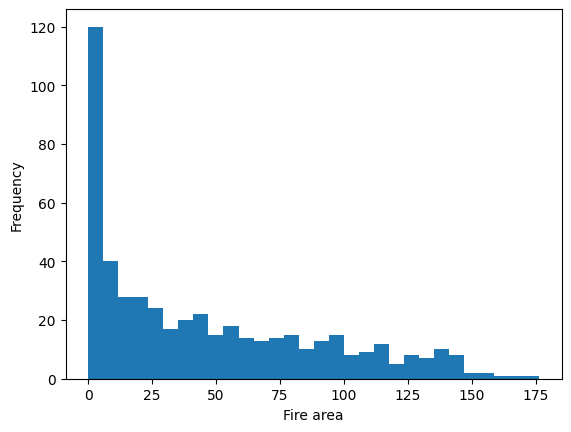

In [117]:

plt.hist(df.loc[:,"area"], bins = 30) 
plt.xlabel("Fire area")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

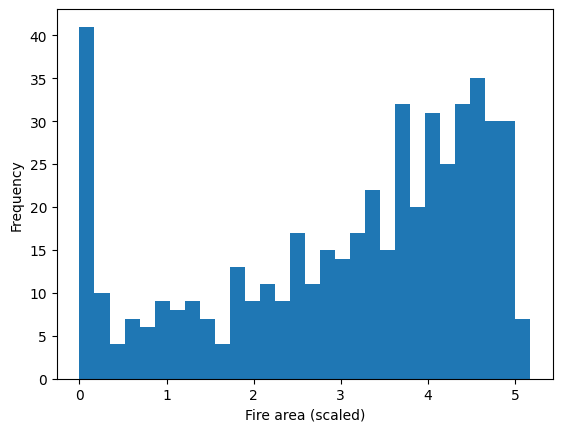

In [124]:
plt.hist(df.loc[:,"log_area"], bins = 30) 
plt.xlabel("Fire area (scaled)")
plt.ylabel("Frequency")

In [131]:
def q(s_r,s):
    if s < s_r:
        return 0.9
    else:
        return 0.1

def o(s_r, s):
    return max(0.01, 0.05*s)*q(s_r,s) + 0.85*s*(1-q(s_r,s))

def C(r,s):
    if r == "none":
        s_r = 0
        c_r = 0
    elif r == "small":
        s_r = 40
        c_r = 30000
    elif r == "medium":
        s_r = 120
        c_r = 100000
    elif r == "large":
        s_r = 2000
        c_r = 500000
    return 20000*o(s_r, s) + c_r
    

In [134]:
print("Cost of nothing", C("none", 60))
print("Cost of small", C("small", 60))
print("Cost of medium", C("medium", 60))
print("Cost of large", C("large", 60))

Cost of nothing 923999.9999999999
Cost of small 953999.9999999999
Cost of medium 255999.99999999997
Cost of large 656000.0


In [29]:
print("Cost of nothing", C("nothing", 60))
print("Cost of small", C(40,60, 30000))
print("Cost of medium", C(120,60, 100000))
print("Cost of large", C(2000,60, 500000))

Cost of nothing 923999.9999999999
Cost of small 953999.9999999999
Cost of medium 255999.99999999997
Cost of large 656000.0


In [33]:
print("Cost of nothing", C(0,6, 0))
print("Cost of small", C(40,6, 30000))
print("Cost of medium", C(120,6, 100000))
print("Cost of large", C(2000,6, 500000))

Cost of nothing 92400.0
Cost of small 45600.0
Cost of medium 115600.0
Cost of large 515600.0


In [34]:
print("Cost of nothing", C(0,2, 0))
print("Cost of small", C(40,2, 30000))
print("Cost of medium", C(120,2, 100000))
print("Cost of large", C(2000,2, 500000))

Cost of nothing 30800.0
Cost of small 35200.0
Cost of medium 105200.0
Cost of large 505200.0


In [35]:
print("Cost of nothing", C(0,2002, 0))
print("Cost of small", C(40,2002, 30000))
print("Cost of medium", C(120,2002, 100000))
print("Cost of large", C(2000,2002, 500000))

Cost of nothing 30830800.0
Cost of small 30860800.0
Cost of medium 30930800.0
Cost of large 31330800.0


In [15]:
df.columns

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area', 'log_area'],
      dtype='object')

In [31]:
y = df.loc[:,"log_area"]
X = df.loc[:,["X", "Y", "FFMC","DMC", "DC", "ISI", "temp","RH", "wind", "rain"]]

In [32]:
X_train1, X_test, y_train1, y_test = train_test_split(X,y, test_size = 0.2)

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train1,y_train1, test_size = 0.2)

In [129]:
# Linear Regression Baseline
linReg = LinearRegression()
linReg.fit(X_train, y_train)
lm_pred = linReg.predict(X_test)
print(r2_score(lm_pred, y_test))
print(mean_squared_error(lm_pred, y_test))

0.937913395851338
0.1403429049181779


In [36]:
# Hyperparameter tuning:
def tune_ridge(train_X, train_y, val_X, val_y, params):
    rmse = []
    mae = []
    for  a in params:
        model = Ridge(alpha = a)
        model.fit(train_X, train_y)
        val_pred = model.predict(val_X)
        val_rmse = mean_squared_error(val_y, val_pred)
        rmse.append(val_rmse)
        val_mae = mean_absolute_error(val_y, val_pred)
        mae.append(val_mae)
    output = pd.DataFrame({"alpha" : params, "rmse" : rmse, "mae" : mae})
    return output

In [38]:
print(tune_ridge(X_train, y_train, X_val, y_val, [10,1,0.1,0.01,0.001, 0.0001, 0.00001]))

      alpha      rmse       mae
0  10.00000  0.287495  0.426058
1   1.00000  0.151289  0.343345
2   0.10000  0.149955  0.348327
3   0.01000  0.150062  0.348990
4   0.00100  0.150075  0.349057
5   0.00010  0.150077  0.349064
6   0.00001  0.150077  0.349064


In [55]:
model = Ridge(alpha = 0.1)
model.fit(X_train, y_train)
ridge_pred = model.predict(X_val)
ridge_test = model.predict(X_test)

In [63]:
mean_squared_error(ridge_test, y_test)

0.1399030381092967

In [65]:
r2_score(ridge_test, y_test)

0.9376306768893321

Text(0.5, 1.0, 'Ridge Regression with best hyperparameters')

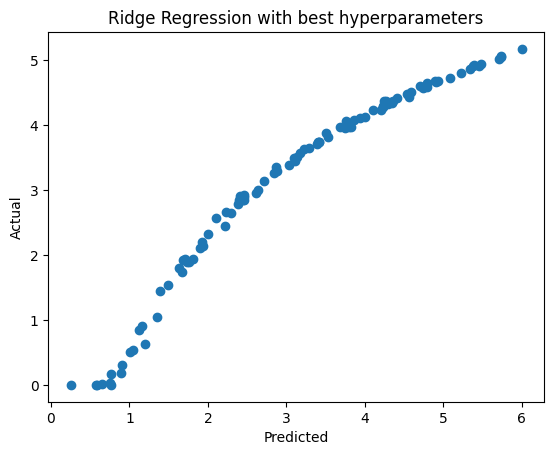

In [56]:
plt.scatter(ridge_test, y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ridge Regression with best hyperparameters")

Text(0.5, 1.0, 'Ridge Regression with best hyperparameters')

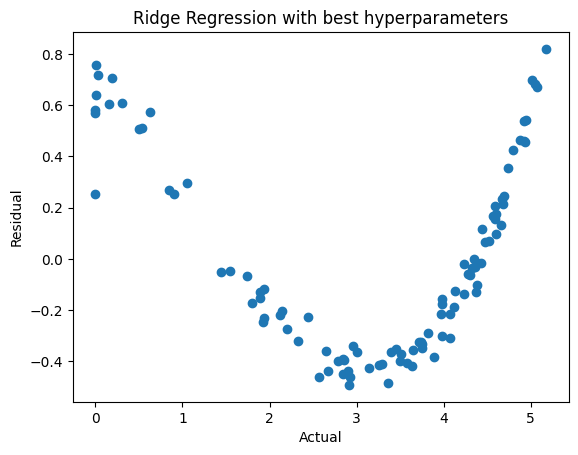

In [57]:
plt.scatter(y_test, ridge_test - y_test)
plt.xlabel("Actual")
plt.ylabel("Residual")
plt.title("Ridge Regression with best hyperparameters")
# note the pattern- clearly there is something going on here....

In [46]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [3, 5, 7, 9, 25],
    'max_features': [1,2, "sqrt", None, "log2"],
    'min_samples_leaf': [1,3, 5, 7],
    'min_samples_split': [2, 4, 8, 16, 32],
    'n_estimators': [25, 100, 150, 300, 500]
}

In [47]:
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits
[CV] END bootstrap=True, max_depth=3, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=1, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=25; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=25; total time=   0.0s
[CV] END bootstrap=True, max_depth=3, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=150; total time=   0.2s
[CV] END bootstrap=True, max_depth=3, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.8s
[CV] END boots

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [3, 5, 7, 9, 25],
                         'max_features': [1, 2, 'sqrt', None, 'log2'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 8, 16, 32],
                         'n_estimators': [25, 100, 150, 300, 500]},
             verbose=2)

In [58]:
best_grid = grid_search.best_estimator_
print(best_grid)

best_pred = best_grid.predict(X_val)
print(mean_squared_error(best_pred, y_val))
print(mean_absolute_error(best_pred, y_val))

best_test = best_grid.predict(X_test)

# therefore, random forests performs better

RandomForestRegressor(max_depth=7, max_features=None)
0.03329885651632999
0.1314005396263836


In [59]:
print(best_grid)

RandomForestRegressor(max_depth=7, max_features=None)


In [62]:
mean_squared_error(best_test, y_test)

0.03805337554830033

In [66]:
r2_score(best_test, y_test)

0.9821084849537385

Text(0.5, 1.0, 'Random forests with best hyperparameters')

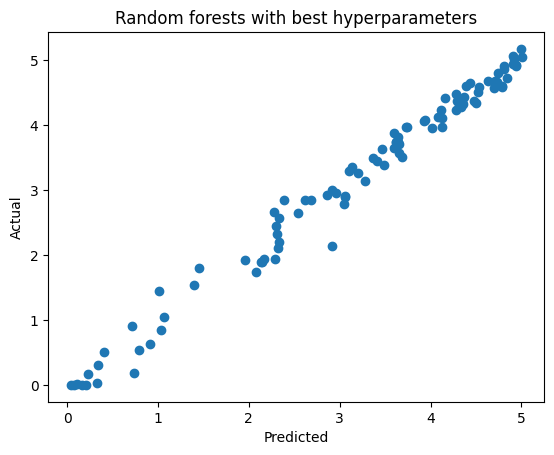

In [60]:
plt.scatter(best_test, y_test)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random forests with best hyperparameters")

Text(0.5, 1.0, 'Random forests with best hyperparameters')

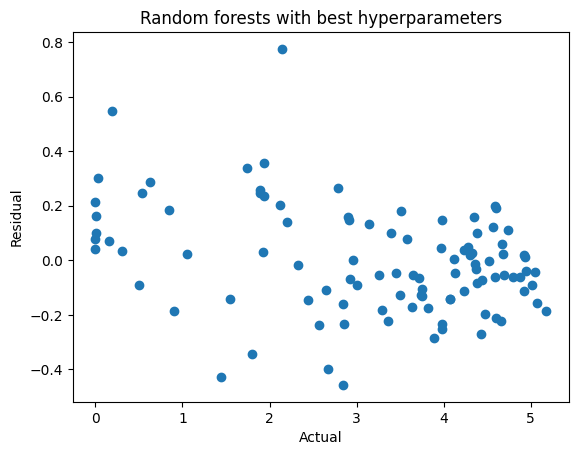

In [61]:
plt.scatter(y_test, best_test - y_test)
plt.xlabel("Actual")
plt.ylabel("Residual")
plt.title("Random forests with best hyperparameters")

Text(0.5, 1.0, 'Random forests with best hyperparameters')

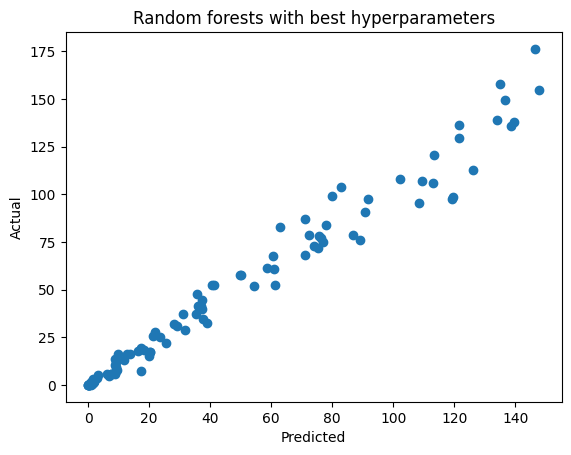

In [69]:
best_test_area = np.exp(best_test)-1
test_area = np.exp(y_test)-1
plt.scatter(best_test_area, test_area)
plt.xlabel("Predicted(ha)")
plt.ylabel("Actual (ha)")
plt.title("Random forests with best hyperparameters")

In [80]:
print(mean_squared_error(best_test_area, test_area))
print(np.sqrt(mean_squared_error(best_test_area, test_area)))
print(np.sqrt(mean_squared_error(best_test_area, test_area))/ np.mean(test_area))
print(mean_absolute_error(best_test_area, test_area))
print(mean_absolute_error(best_test_area, test_area)/ np.mean(test_area))
print(r2_score(best_test_area, test_area))

64.40998343818306
8.02558305907945
0.1645701250350791
5.315062560791988
0.1089890296766968
0.9671553522610413


Text(0.5, 1.0, 'Random forests with best hyperparameters')

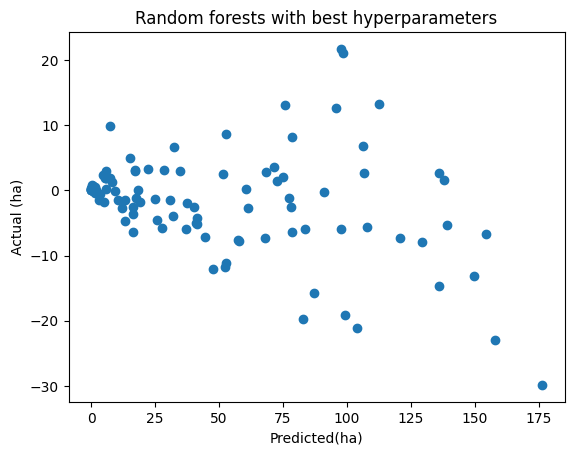

In [73]:
plt.scatter(test_area, best_test_area - test_area)
plt.xlabel("Predicted(ha)")
plt.ylabel("Actual (ha)")
plt.title("Random forests with best hyperparameters")

In [81]:
predicted_df = pd.DataFrame({
    "predicted_ha" : best_test_area,
    "actual_ha": test_area
})

In [105]:
bins = [-1,2.3437, 40, 120, 2000, 1000000]
cats = ["none", "small", "medium", "large", "none"]
predicted_df["predicted_response"] = pd.cut(predicted_df["predicted_ha"], bins = bins, labels = cats, ordered = False)
predicted_df["actual_response"] = pd.cut(predicted_df["actual_ha"], bins = bins, labels = cats, ordered = False)

In [106]:
predicted_df

,predicted_ha,actual_ha,predicted_response,actual_response
175,1.086954,0.207,none,none
435,7.767044,5.914,small,small
367,6.073480,5.849,small,small
74,9.334040,7.992,small,small
76,17.390003,19.137,small,small
...,...,...,...,...
166,1.049523,1.467,none,none
8,121.513234,129.401,large,large
191,35.405133,37.371,small,small
477,60.561540,67.857,medium,medium


In [107]:
print(predicted_df["predicted_response"].unique())
print(predicted_df["actual_response"].unique())

['none', 'small', 'large', 'medium']
Categories (4, object): ['large', 'medium', 'none', 'small']
['none', 'small', 'large', 'medium']
Categories (4, object): ['large', 'medium', 'none', 'small']


In [110]:
confusion_matrix(predicted_df["predicted_response"], predicted_df["actual_response"], labels = ["none", "small", "medium", "large"])

array([[15,  1,  0,  0],
       [ 0, 36,  6,  0],
       [ 0,  0, 31,  1],
       [ 0,  0,  1,  9]])

In [136]:
predicted_df["predicted_cost"] = predicted_df.apply(
    lambda row: C(row["predicted_response"], row["actual_ha"]), axis=1
)
predicted_df["actual_cost"] = predicted_df.apply(
    lambda row: C(row["actual_response"], row["actual_ha"]), axis=1
)
predicted_df["d_cost"] = predicted_df["predicted_cost"]-predicted_df["actual_cost"]

In [141]:
sum(predicted_df["d_cost"])/len(predicted_df["d_cost"])

44156.0

In [147]:
max(predicted_df["d_cost"])

1142988.8000000003

In [143]:
len(predicted_df["d_cost"])

100

In [139]:
predicted_df

,predicted_ha,actual_ha,predicted_response,actual_response,predicted_cost,actual_cost,d_cost
175,1.086954,0.207,none,none,3187.8,3187.8,0.0
435,7.767044,5.914,small,small,45376.4,45376.4,0.0
367,6.073480,5.849,small,small,45207.4,45207.4,0.0
74,9.334040,7.992,small,small,50779.2,50779.2,0.0
76,17.390003,19.137,small,small,79756.2,79756.2,0.0
...,...,...,...,...,...,...,...
166,1.049523,1.467,none,none,22591.8,22591.8,0.0
8,121.513234,129.401,large,large,836442.6,836442.6,0.0
191,35.405133,37.371,small,small,127164.6,127164.6,0.0
477,60.561540,67.857,medium,medium,276428.2,276428.2,0.0


Text(0, 0.5, 'Frequency')

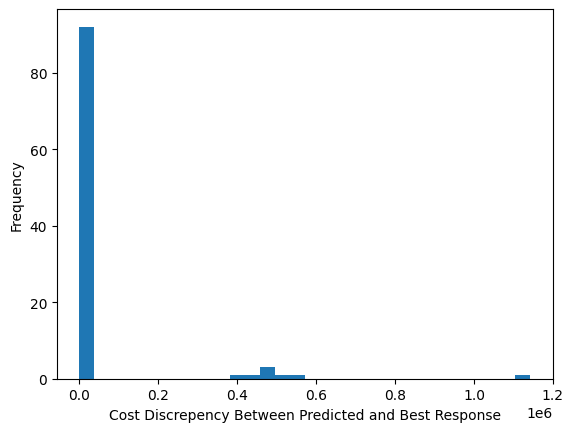

In [151]:
plt.hist(predicted_df["d_cost"], bins = 30)
plt.xlabel("Cost Discrepency Between Predicted and Best Response")
plt.ylabel("Frequency")